# # Clustering Analysis with K-Means

# Required libraries

In [26]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import pymysql
pymysql.install_as_MySQLdb()
import sys
import os

 # Load and preprocess data

In [27]:
# Add project path
sys.path.append(os.path.abspath(".."))

# Import database connection module
from database.db_connection import DatabaseConnector

# Handle database connection
try:
    db_connector = DatabaseConnector()
    engine = db_connector.get_engine()
except Exception as e:
    print(f"Error connecting to the database: {e}")
    sys.exit(1)  # Exit on connection failure

# Load data from the database
try:
    data = pd.read_sql("SELECT relative_humidity_2m, wind_speed_10m, temperature_2m FROM historical_weather;", engine)
except Exception as e:
    print(f"Error loading data from the database: {e}")
    sys.exit(1)  # Exit on data loading failure

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

 # K-Means Clustering

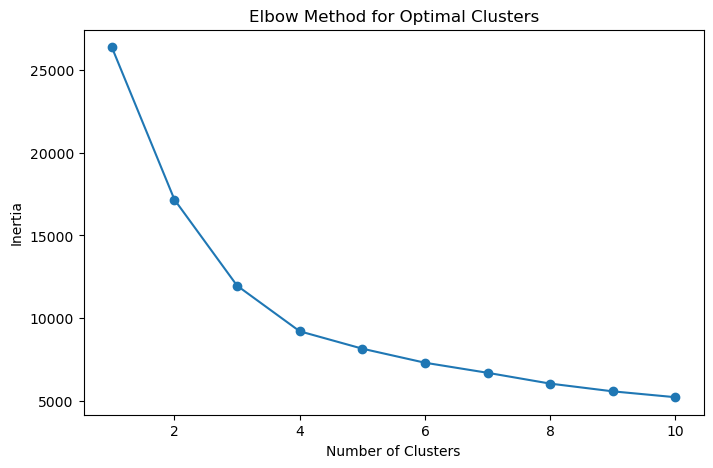

In [28]:
# Determine the optimal number of clusters using the elbow method
inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

 # Based on the elbow method, choose an appropriate number of clusters.

In [29]:
# Fit the K-Means model
optimal_clusters = 3  # Adjust this based on the elbow curve
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Calculate silhouette score
silhouette_avg = silhouette_score(data_scaled, data['Cluster'])
print(f"Silhouette Score for {optimal_clusters} clusters: {silhouette_avg:.2f}")

Silhouette Score for 3 clusters: 0.39


# Interpretation

A score of 0.39 suggests that the clusters have some degree of separation, but there is also noticeable overlap between the clusters.
Dataset Characteristics:

Given that the features used (relative_humidity_2m, wind_speed_10m, and temperature_2m) are continuous and may not naturally form distinct groups, this score is expected. Weather data often exhibits smooth gradients rather than sharp boundaries.

 # Visualization of Clusters

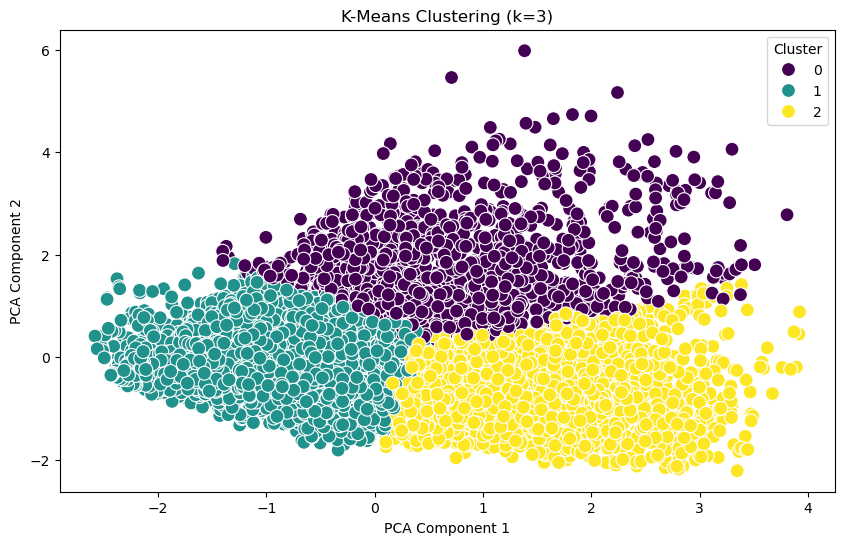

In [30]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
data['PCA1'] = data_pca[:, 0]
data['PCA2'] = data_pca[:, 1]

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data, palette='viridis', s=100)
plt.title(f"K-Means Clustering (k={optimal_clusters})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()

# Interpretation

The graph illustrates the results of K-Means clustering with three clusters (k=3), projected onto two principal components using PCA. While the clusters show general separation, there is moderate overlap, especially between the teal and purple clusters, indicating that the data points are not completely distinct. This overlap aligns with the silhouette score of 0.39, suggesting only moderate clustering quality

 # Cluster Analysis

Cluster Centers:
   relative_humidity_2m  wind_speed_10m  temperature_2m
0             76.761940       14.769140        9.323659
1             91.073495        4.529300        7.867045
2             66.896402        5.319419       19.572735


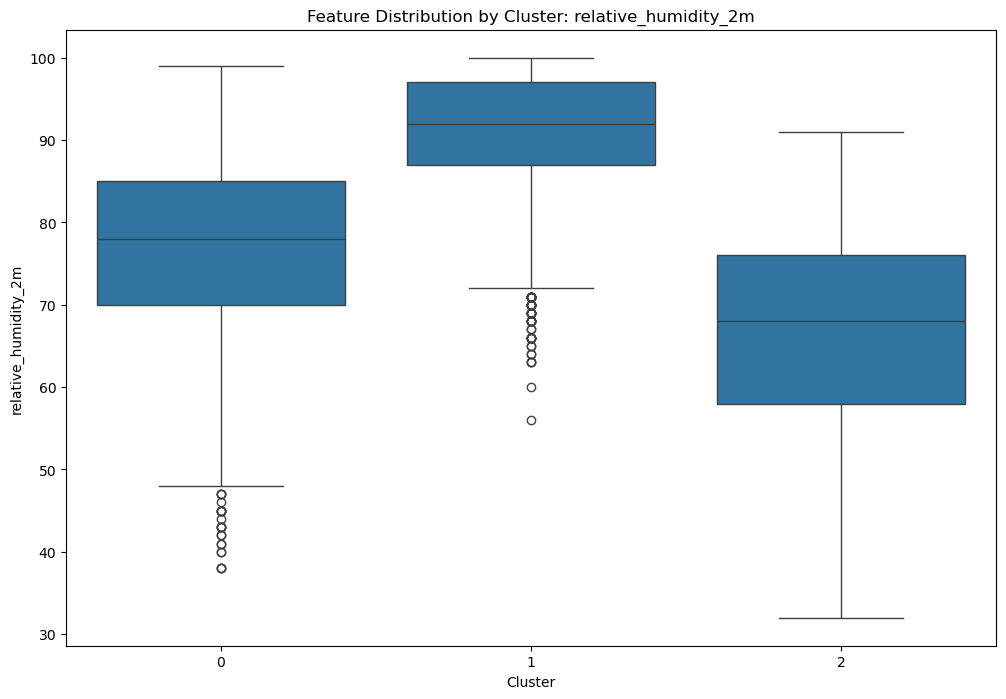

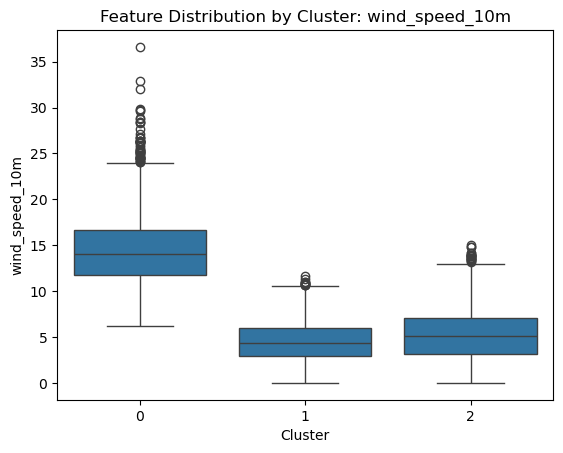

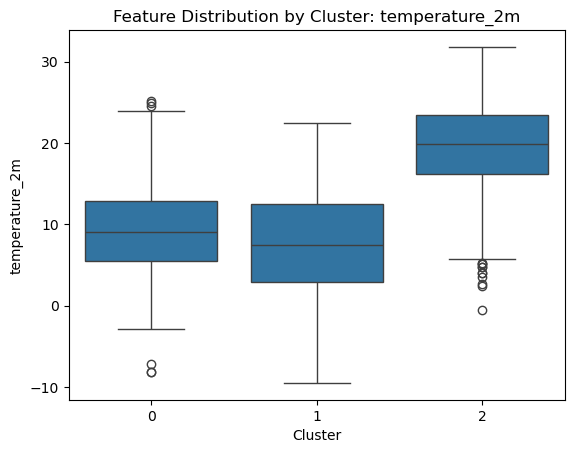

Clustering results saved to 'kmeans_clustering_results.csv'.


In [31]:
# Analyze the cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=data.columns[:-3])  # Adjust as needed
print("Cluster Centers:")
print(cluster_centers_df)

# Boxplot of features by cluster
plt.figure(figsize=(12, 8))
for feature in data.columns[:-3]:
    sns.boxplot(x='Cluster', y=feature, data=data)
    plt.title(f"Feature Distribution by Cluster: {feature}")
    plt.show()

# %% [markdown]
# # # Save and Export Results

# %%
# Save clustering results to CSV
data.to_csv("kmeans_clustering_results.csv", index=False)
print("Clustering results saved to 'kmeans_clustering_results.csv'.")

# Interpretaion

The three boxplots provide a detailed view of the distribution of the features (relative humidity, wind speed, and temperature) across the three identified clusters.

Relative Humidity: Cluster 1 is characterized by the highest relative humidity values, with a median close to 90% and relatively low variability. Cluster 0 exhibits moderate humidity, with a median around 75%, while Cluster 2 has the lowest humidity, with a median below 70% and higher variability. This suggests that Cluster 1 represents a highly humid environment compared to the other clusters.

Wind Speed: Cluster 0 shows significantly higher wind speeds, with a median close to 15 m/s and a broader range of variability, including many outliers. Clusters 1 and 2, in contrast, have much lower wind speeds, with medians around 5 m/s, indicating calmer conditions. This distinction suggests that Cluster 0 may represent windy conditions, while Clusters 1 and 2 are associated with calmer weather.

Temperature: Cluster 2 exhibits the highest temperatures, with a median near 20°C and a relatively broad range extending above 30°C. Cluster 0 displays moderate temperatures, with a median around 10°C, while Cluster 1 has the lowest temperatures, with a median close to 8°C. This pattern indicates that Cluster 2 is associated with warmer conditions, while Cluster 1 represents cooler environments.

Together, the clusters effectively differentiate weather conditions based on humidity, wind speed, and temperature. Cluster 1 represents cool and humid conditions with low wind speeds, Cluster 2 captures warm and dry conditions with moderate wind, and Cluster 0 signifies windy conditions with moderate temperatures and humidity. These insights are essential for interpreting environmental patterns and their implications.

 # Save and Export Results

In [32]:
# Save clustering results to CSV
data.to_csv("results/kmeans_clustering_results.csv", index=False)
print("Clustering results saved to 'kmeans_clustering_results.csv'.")

Clustering results saved to 'kmeans_clustering_results.csv'.
